In [23]:
import SparseVector_pb2 as SP
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
import sys
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
with open("test_bed/files/H3", mode='rb') as f:
    sp = SP.SparseVector()
    sp.ParseFromString(f.read())

In [6]:
features = [i for i in os.listdir('test_bed/oth_bon/')]
features 

['AAV',
 'AGO2',
 'AR',
 'ARNT',
 'ARNTL',
 'ATR',
 'BMI1',
 'BRCA1',
 'BRD4',
 'CASP8AP2',
 'CBFB',
 'CBX5',
 'CDC73',
 'CDK12',
 'CEBPB',
 'CHD1',
 'CLOCK',
 'CPSF1',
 'CPSF3',
 'CPSF6',
 'CRY1',
 'CSTF2',
 'CTCF',
 'CTCFL',
 'CTR9',
 'CUL4A',
 'DDIT3',
 'DROSHA',
 'DTL',
 'E2F1',
 'E2F3',
 'EP300',
 'EP400',
 'EPAS1',
 'Epitope',
 'ERCC2',
 'ERCC3',
 'ERG',
 'ESR1',
 'ESR2',
 'ETV6',
 'EWSR1',
 'EZH2',
 'FANCD2',
 'FLI1',
 'FOS',
 'FOSL1',
 'FOSL2',
 'FOXM1',
 'FOXO1',
 'GABPA',
 'GLI1',
 'GLI2',
 'G-quadruplex',
 'GTF2F1',
 'HIF1A',
 'HNF1B',
 'HSF1',
 'JUNB',
 'JUND',
 'KLF15',
 'KLF4',
 'MCM5',
 'MED26',
 'MEIS1',
 'MEN1',
 'MYBL2',
 'MYC',
 'NABP2',
 'NAT10',
 'NCOA1',
 'NELFCD',
 'NELFE',
 'NKX2-2',
 'NPAT',
 'NR3C1',
 'PAF1',
 'PAX8',
 'PBXIP1',
 'PCNA',
 'PPP1R10',
 'RAD21',
 'RAD51',
 'RB1',
 'RELA',
 'RNF2',
 'RUNX2',
 'RUVBL2',
 'SETDB1',
 'SFPQ',
 'SIRT3',
 'SMAD1',
 'SMC1A',
 'SSRP1',
 'STAG1',
 'STAG2',
 'STAT3',
 'SUMO1',
 'SUMO2',
 'SUPT5H',
 'SUPT6H',
 'TAF15',
 'TBP

In [7]:
dna = {}
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

In [9]:
for feat in tqdm(features):
    with open(f"test_bed/oth_bon/{feat}", mode='rb') as f:
        sp = SP.SparseVector()
        sp.ParseFromString(f.read())
        for key in chrom_names:
            data = [0]
            data.extend(sp.chromosomes[key].data)
            data.append(0)
            indices = [0]
            indices.extend(sp.chromosomes[key].indices)
            indices.append(indices[-1])
            shape  = sp.chromosomes[key].size
            sparsearray = SparseVector((np.array(data), np.array(indices)), shape)
            if feat not in dna:
                dna[feat] = {}  # Создание пустого словаря, если ключ отсутствует
            dna[feat][key] = sparsearray  # Присваивание значения ключу

  0%|          | 0/149 [00:00<?, ?it/s]

In [10]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [11]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("bone.bed", "r") as bed_file:

    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [12]:
win_in = []
win_out = []
width = 5000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
print(len(win_in), len(win_out))

2424 14517


In [14]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]

In [15]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr12', '47833964', '47838964', '0'],
       ['chr15', '45267509', '45272509', '0'],
       ['chr9', '119701794', '119706794', '0'],
       ['chr22', '29383120', '29388120', '0'],
       ['chr4', '6068333', '6073333', '0'],
       ['chr1', '1815149', '1820149', '0'],
       ['chr18', '76634016', '76639016', '0'],
       ['chr7', '152570131', '152575131', '0'],
       ['chr21', '38382787', '38387787', '1'],
       ['chr17', '82914133', '82919133', '0']], dtype='<U21')

In [16]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in features:
        source = dna[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row) 
        y.append(target)
    else:
        continue 

pbar.close()

100%|███████████████████████████████████████████████████████████████████████████| 7272/7272 [00:47<00:00, 154.57it/s]


In [18]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [19]:
X = np.array(X)
X

array([[ 1.221869  , -0.16379432, -0.08878558, ..., -0.23480912,
        -0.15170707,  2.2191834 ],
       [ 2.7155032 , -0.16379432, -0.2898074 , ..., -0.72444165,
         0.20324785,  0.7187941 ],
       [-0.9894276 , -0.16379432,  0.4494342 , ..., -0.14413643,
        -0.8874318 , -0.52250737],
       ...,
       [-0.43323946, -0.16379432, -0.30277658, ..., -0.16831581,
        -0.8874318 , -0.9401415 ],
       [-0.9894276 , -0.16379432,  1.9603403 , ..., -0.72444165,
         0.28069255, -0.6423838 ],
       [ 2.1951983 , -0.16379432,  1.046015  , ...,  0.09161258,
        -0.05490118,  1.0088179 ]], dtype=float32)

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))

2023-05-15 00:58:06.958958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 00:58:07.719714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
182/182 [==============================] - 2s 9ms/step - loss: 0.6463 - accuracy: 0.6620 - val_loss: 0.6309 - val_accuracy: 0.6838
Epoch 2/10
182/182 [==============================] - 2s 8ms/step - loss: 0.6406 - accuracy: 0.6624 - val_loss: 0.6272 - val_accuracy: 0.6838
Epoch 3/10
182/182 [==============================] - 2s 9ms/step - loss: 0.6405 - accuracy: 0.6624 - val_loss: 0.6243 - val_accuracy: 0.6838
Epoch 4/10
182/182 [==============================] - 2s 8ms/step - loss: 0.6406 - accuracy: 0.6624 - val_loss: 0.6248 - val_accuracy: 0.6838
Epoch 5/10
182/182 [==============================] - 2s 9ms/step - loss: 0.6403 - accuracy: 0.6624 - val_loss: 0.6245 - val_accuracy: 0.6838
Epoch 6/10
182/182 [==============================] - 2s 9ms/step - loss: 0.6398 - accuracy: 0.6624 - val_loss: 0.6270 - val_accuracy: 0.6838
Epoch 7/10
182/182 [==============================] - 1s 8ms/step - loss: 0.6399 - accuracy: 0.6624 - val_loss: 0.6276 - val_accuracy: 0.6838
Epoch 

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device) 
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    # Оценка на тестовом наборе данных
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_2498/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_2498/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6850, Train F1-score: 0.5491, Train ROC-AUC: 0.4893, Train PR-AUC: 0.3308, Test Loss: 0.6758, Test F1-score: 0.5555, Test ROC-AUC: 0.5026, Test PR-AUC: 0.3125
Epoch [2/20], Train Loss: 0.6715, Train F1-score: 0.5278, Train ROC-AUC: 0.5102, Train PR-AUC: 0.3462, Test Loss: 0.6600, Test F1-score: 0.5555, Test ROC-AUC: 0.4919, Test PR-AUC: 0.3041
Epoch [3/20], Train Loss: 0.6589, Train F1-score: 0.5278, Train ROC-AUC: 0.4984, Train PR-AUC: 0.3382, Test Loss: 0.6446, Test F1-score: 0.5555, Test ROC-AUC: 0.4880, Test PR-AUC: 0.3050
Epoch [4/20], Train Loss: 0.6472, Train F1-score: 0.5278, Train ROC-AUC: 0.5166, Train PR-AUC: 0.3476, Test Loss: 0.6340, Test F1-score: 0.5555, Test ROC-AUC: 0.4846, Test PR-AUC: 0.3023
Epoch [5/20], Train Loss: 0.6423, Train F1-score: 0.5278, Train ROC-AUC: 0.5130, Train PR-AUC: 0.3406, Test Loss: 0.6292, Test F1-score: 0.5555, Test ROC-AUC: 0.4862, Test PR-AUC: 0.3054
Epoch [6/20], Train Loss: 0.6390, Train F1-score: 0.5278, Train R

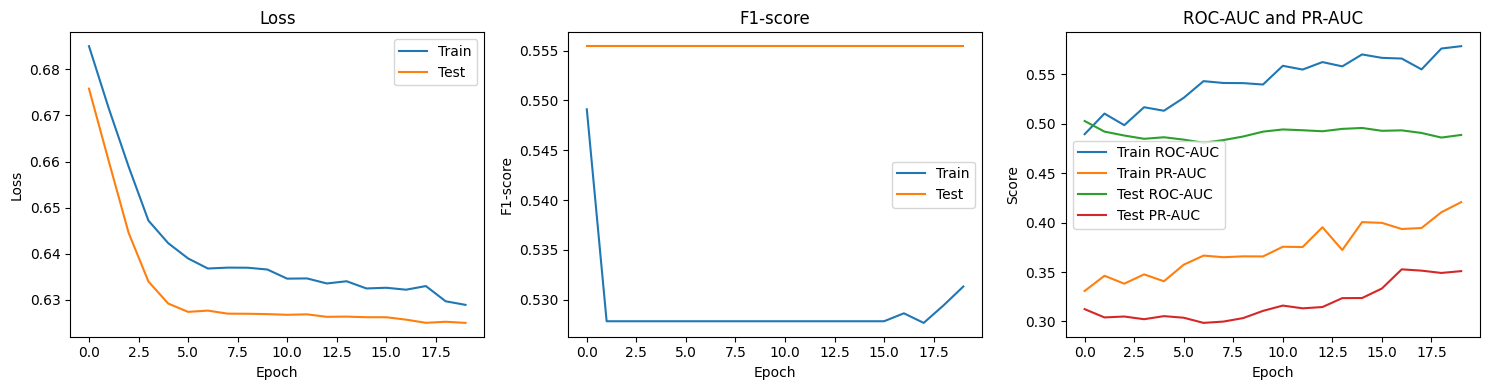

In [25]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [28]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=features)
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [30]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
    verbose=200
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6795706	total: 3.04ms	remaining: 3.04s
200:	learn: 0.5421735	total: 536ms	remaining: 2.14s
400:	learn: 0.5046717	total: 1.07s	remaining: 1.61s
600:	learn: 0.4809603	total: 1.59s	remaining: 1.06s
800:	learn: 0.4637495	total: 2.12s	remaining: 527ms
999:	learn: 0.4496103	total: 2.65s	remaining: 0us
F1: 0.3311603650586702, AUC-ROC: 0.547591216954337, PR-ROC: 0.34307784738880764
